In [1]:
import sys
import tensorflow as tf
import cv2
import time
import argparse
import os
from PIL import Image
import numpy as np
import math

In [2]:
posenet_path = 'E:\\projects\\pg-toons\\posenet-python'
sys.path.append(posenet_path)

In [3]:
import posenet

In [4]:
# # webcam
# with tf.Session() as sess:
#     model_cfg, model_outputs = posenet.load_model(101, sess) # 101 = mobilenetv1 model converted from tfjs
    
#     output_stride = model_cfg['output_stride']
    
#     cap = cv2.VideoCapture(os.path.join(posenet_path, '..\\', 'aladdin.mp4'))
    
#     frame_count = 0
#     start_time = time.time()
    
#     while True:
#         # read frame
#         input_image, display_image, output_scale = posenet.read_cap(cap, scale_factor=0.7125, output_stride=output_stride)
        
#         # run model for inference
#         heatmaps_result, offsets_result, displacement_fwd_result, displacement_bwd_result = sess.run(
#             model_outputs,
#             feed_dict={'image:0': input_image}
#         )
        
#         pose_scores, keypoint_scores, keypoint_coords = posenet.decode_multi.decode_multiple_poses(
#             heatmaps_result.squeeze(axis=0),
#             offsets_result.squeeze(axis=0),
#             displacement_fwd_result.squeeze(axis=0),
#             displacement_bwd_result.squeeze(axis=0),
#             output_stride=output_stride,
#             max_pose_detections=10,
#             min_pose_score=0.15
#         )
        
#         keypoint_coords *= output_scale
        
#         overlay_image, _, _ = posenet.draw_skel_and_kp(
#             display_image, pose_scores, keypoint_scores, keypoint_coords, min_pose_score=0.15, min_part_score=0.1
#         )
        
#         cv2.imwrite(os.path.join(posenet_path, '..\\', 'frames', f'frame{frame_count}.jpg'), display_image)
#         cv2.imwrite(os.path.join(posenet_path, '..\\', 'frames_overlay', f'frame{frame_count}.jpg'), overlay_image)
# #         cv2.imshow('posenet', overlay_image)
        
#         frame_count += 1
        
#         k = cv2.waitKey(1) & 0xFF
#         if k == ord('q'):
#             break
            
#     print('Average FPS: ', frame_count / (time.time() - start_time))
#     cv2.destroyAllWindows()

In [5]:
# image
with tf.Session() as sess:
    model_cfg, model_outputs = posenet.load_model(101, sess)
    output_stride = model_cfg['output_stride']

    filenames = [os.path.join(posenet_path, '..\\', 'image.jpg')]
    start_time = time.time()
    for f in filenames:
        input_image, orig_image, output_scale = posenet.read_imgfile(
            f, scale_factor=1, output_stride=output_stride)

        heatmaps_result, offsets_result, displacement_fwd_result, displacement_bwd_result = sess.run(
            model_outputs,
            feed_dict={'image:0': input_image}
        )

        pose_scores, keypoint_scores, keypoint_coords = posenet.decode_multiple_poses(
            heatmaps_result.squeeze(axis=0),
            offsets_result.squeeze(axis=0),
            displacement_fwd_result.squeeze(axis=0),
            displacement_bwd_result.squeeze(axis=0),
            output_stride=output_stride,
            max_pose_detections=10,
            min_pose_score=0.25)

        keypoint_coords *= output_scale

        draw_image, keypoints, adjacent_keypoints = posenet.draw_skel_and_kp(
            orig_image, pose_scores, keypoint_scores, keypoint_coords,
            min_pose_score=0.25, min_part_score=0.25)

        cv2.imwrite(os.path.join(posenet_path, '..\\', 'image_overlay.jpg'), draw_image)
        
    print('Average FPS:', len(filenames) / (time.time() - start_time))


E:\projects\pg-toons\posenet-python\posenet\converter\config.py:9: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  cfg = yaml.load(cfg_f)


Average FPS: 0.3587801264929056


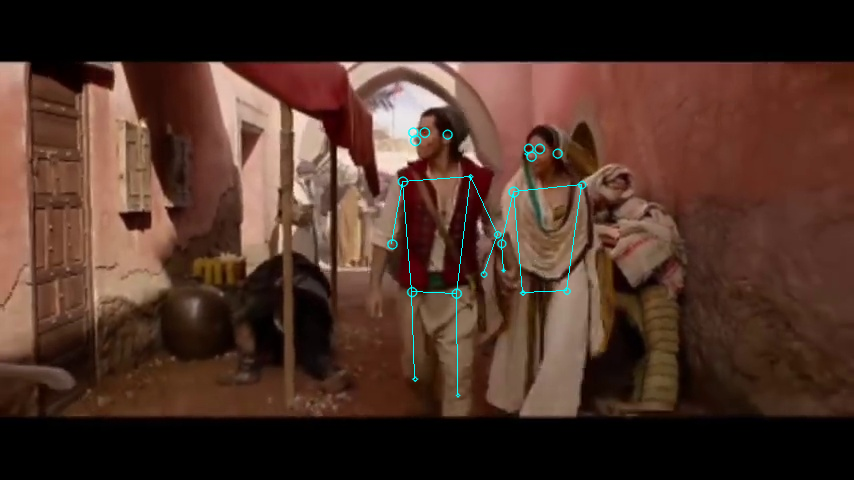

In [6]:
x, y = list(map(int, keypoints[0][1]))
draw_image[x, y] = (0, 0, 255)
Image.fromarray(cv2.cvtColor(draw_image, cv2.COLOR_BGR2RGB))

[[140.10507564 415.13567471]
 [132.1441533  424.32207793]
 [132.05499217 412.83449418]
 [134.11385138 447.11793624]
 [136.8903722  413.11333075]
 [176.11467228 470.14581197]
 [181.27042743 402.50345873]
 [234.24298039 497.26054926]
 [243.87306229 391.91886018]
 [273.87546627 483.59007939]
 [292.78680274 388.88316247]
 [293.17315623 456.23519882]
 [291.60272991 411.67691225]
 [394.94287693 457.63598783]
 [378.6565101  414.72250457]
 [477.4294262  452.64420126]
 [433.41285031 423.83091098]]


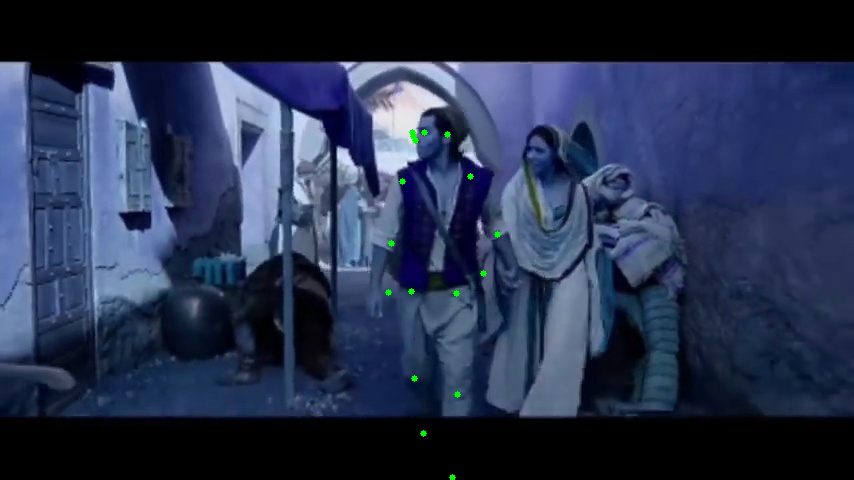

In [7]:
# skeleton_area = np.zeros(draw_image.shape).astype(np.uint8)
skeleton_area = orig_image.copy()
height, width, channels = draw_image.shape

for skeleton_coords in keypoint_coords[0:1]:
    print(skeleton_coords)
    for coord in skeleton_coords:
        y, x = list(map(int, coord))
        if x >= 0 and x < width and y >= 0 and y < height:
            cv2.circle(skeleton_area, (x, y), 3, (0, 255, 0), -1)
            
Image.fromarray(skeleton_area)

In [42]:
def make_ball(point, radius):
    return (point, radius)

def draw_ball(canvas, ball, colour=(0,255,0)):
    centre, radius = ball
    cv2.circle(canvas, centre, radius, colour, -1)
    return canvas

def get_slope_interc(p1, p2):
    if p1[0] == p2[0]:
        return None, None
    slope = (p1[1] - p2[1]) / (p1[0] - p2[0])
    interc = p1[1] - slope * p1[0]
    return slope, interc

def get_points(cur_point, slope, interc, dist):
    m, n = cur_point
    disc = math.sqrt((dist**2 * slope**2) - (m**2 * slope**2) + (2 * m * n * slope) - (2 * m * interc * slope) + (2 * n * interc) + dist**2 - n**2 - interc**2)
    x1 = (m + n * slope - interc * slope + disc) / (1 + slope**2)
    y1 = slope * x1 + interc
    
    x2 = (m + n * slope - interc * slope - disc) / (1 + slope**2)
    y2 = slope * x2 + interc
    
    return [(x1, y1), (x2, y2)]
    
def make_joint(point, ball, width):
    centre, radius = ball
    slope, interc = get_slope_interc(centre, point)
    
    perpend_slope = -1 / slope
    perpend_interc = centre[1] - perpend_slope * centre[0]
    
    ball_points = get_points(centre, perpend_slope, perpend_interc, width / 2)
    
    perpend_interc = point[1] - perpend_slope * point[0]
    
    key_points = get_points(point, perpend_slope, perpend_interc, width / 2)
    
    return ball_points + key_points
    
def draw_joint(canvas, joint):
    cv2.line(canvas, joint[0], joint[1], (0, 255, 0))
    cv2.line(canvas, joint[0], joint[2], (0, 255, 0))
    cv2.line(canvas, joint[1], joint[3], (0, 255, 0))
    cv2.line(canvas, joint[2], joint[3], (0, 255, 0))
    return canvas

In [43]:
canvas = np.zeros((200, 200, 3)).astype(np.uint8)

thotness = 3

p1 = (80, 80)
p2 = (50, 60)
p3 = (30, 90)

ball2 = make_ball(p2, radius=thotness // 2)
canvas = draw_ball(canvas, ball2)

canvas = draw_ball(canvas, make_ball(p1, radius=thotness // 2))

# joint3 = make_joint(p3, ball2, width=thotness)
joint1 = make_joint(p1, ball2, width=20)
points = [tuple(map(round, point)) for point in joint1]
for point in points:
    canvas = draw_ball(canvas, make_ball(point, radius=thotness // 2), colour=(255, 0, 0))

canvas = draw_joint(canvas, points)

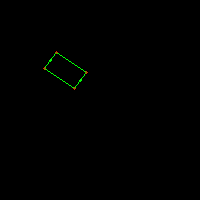

In [44]:
Image.fromarray(canvas)

In [13]:
joint1[0]

(-73.78333432104677, 245.67500148157015)

In [ ]:
math.sqrt((joint1[0][0] - p1[0])**2 + (joint1[0][1] - p1[1])**2)